## Nearest Neighbor item based Collaborative Filtering

#### Load dataset

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
books = pd.read_csv('BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
users = pd.read_csv('BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']
ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

C:\Users\Admin\AppData\Local\Temp\ipykernel_13660\769817491.py:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  books = pd.read_csv('BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
Skipping line 6452: expected 8 fields, saw 9
Skipping line 43667: expected 8 fields, saw 10
Skipping line 51751: expected 8 fields, saw 9

Skipping line 92038: expected 8 fields, saw 9
Skipping line 104319: expected 8 fields, saw 9
Skipping line 121768: expected 8 fields, saw 9

Skipping line 144058: expected 8 fields, saw 9
Skipping line 150789: expected 8 fields, saw 9
Skipping line 157128: expected 8 fields, saw 9
Skipping line 180189: expected 8 fields, saw 9
Skipping line 185738: expected 8 fields, saw 9

Skipping line 209388: expected 8 fields, saw 9
Skipping line 220626: expected 8 fields, saw 9
Skipping line 227933: expected 8 fields, saw 11
Skipping line 228957: expected 8 fields, saw 10

In [46]:
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [47]:
users.head()

,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [48]:
ratings.head()

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


### Q1. How is the distribution of Rating?

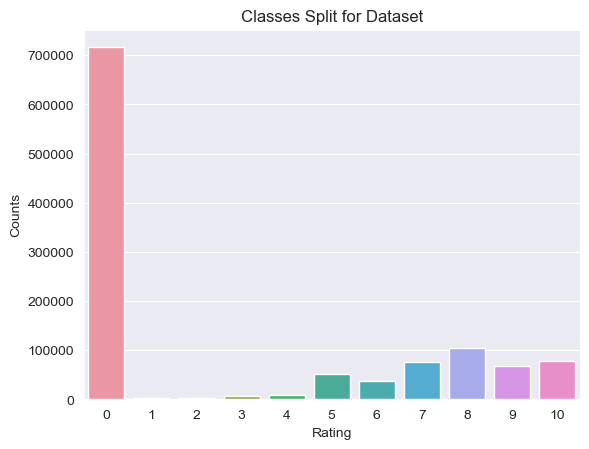

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(data=ratings,x='bookRating').set(title='Classes Split for Dataset', xlabel='Rating',ylabel='Counts')
plt.show()

### Q2. To ensure statistical significance, users with less than 200 ratings, and books with less than 100 ratings are excluded. Write a code for the same.

In [50]:
ratings['user freq'] = ratings.userID.map(ratings.userID.value_counts())
ratings['book freq'] = ratings.bookRating.map(ratings.bookRating.value_counts())

filtered_ratings = ratings[(ratings['user freq'] >= 200) & (ratings['book freq'] >= 100)]
filtered_ratings.reset_index(drop=True)
filtered_ratings = filtered_ratings.drop(columns=['user freq', 'book freq'])
filtered_ratings

,userID,ISBN,bookRating
1456,277427,002542730X,10
1457,277427,0026217457,0
1458,277427,003008685X,8
1459,277427,0030615321,0
1460,277427,0060002050,0
...,...,...,...
1147612,275970,3829021860,0
1147613,275970,4770019572,0
1147614,275970,896086097,0
1147615,275970,9626340762,8


### Q3. Prepare the dataset for KNN. 

In [51]:
ratings_merged = pd.merge(filtered_ratings, books, on='ISBN')
ratings_merged.drop(columns=['bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL'], axis=1, inplace=True)
ratings_merged

,userID,ISBN,bookRating,bookTitle
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...
...,...,...,...,...
488737,275970,1892145022,0,Here Is New York
488738,275970,1931868123,0,There's a Porcupine in My Outhouse: Misadventu...
488739,275970,3411086211,10,Die Biene.
488740,275970,3829021860,0,The Penis Book


In [52]:
ratings_merged['totalRatingCount'] = ratings_merged.bookTitle.map(ratings_merged.bookTitle.value_counts())
ratings_merged

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82
...,...,...,...,...,...
488737,275970,1892145022,0,Here Is New York,1
488738,275970,1931868123,0,There's a Porcupine in My Outhouse: Misadventu...,1
488739,275970,3411086211,10,Die Biene.,1
488740,275970,3829021860,0,The Penis Book,1


#### Filter to users in US and Canada only

In [59]:
us_canada = pd.merge(ratings_merged, users, on='userID')
us_canada = us_canada.drop(columns=['Age'])
us_canada = us_canada[us_canada['Location'].str.contains("usa|canada")].reset_index()
us_canada

,index,userID,ISBN,bookRating,bookTitle,totalRatingCount,Location
0,0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82,"gilbert, arizona, usa"
1,1,277427,0026217457,0,Vegetarian Times Complete Cookbook,7,"gilbert, arizona, usa"
2,2,277427,003008685X,8,Pioneers,1,"gilbert, arizona, usa"
3,3,277427,0030615321,0,"Ask for May, Settle for June (A Doonesbury book)",1,"gilbert, arizona, usa"
4,4,277427,0060002050,0,On a Wicked Dawn (Cynster Novels),13,"gilbert, arizona, usa"
...,...,...,...,...,...,...,...
428081,486447,216012,1583144803,7,First Touch: Serenade/Forever Yours/Beguiled (...,1,"clevelad, ohio, usa"
428082,486448,216012,1583145486,7,Southern Comfort (Arabesque),1,"clevelad, ohio, usa"
428083,486449,216012,1585710164,7,Bound by Love (Indigo: Sensuous Love Stories),1,"clevelad, ohio, usa"
428084,486450,216012,1585710806,7,Tattooed Tears (Indigo: Sensuous Love Stories),1,"clevelad, ohio, usa"


In [69]:
popularity_threshold = 50
us_canada_popular_books = us_canada.query('totalRatingCount >= @popularity_threshold')
us_canada_popular_books

,index,userID,ISBN,bookRating,bookTitle,totalRatingCount,Location
0,0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82,"gilbert, arizona, usa"
13,13,277427,0060930535,0,The Poisonwood Bible: A Novel,133,"gilbert, arizona, usa"
15,15,277427,0060934417,0,Bel Canto: A Novel,108,"gilbert, arizona, usa"
18,18,277427,0061009059,9,One for the Money (Stephanie Plum Novels (Pape...,108,"gilbert, arizona, usa"
24,24,277427,006440188X,0,The Secret Garden,79,"gilbert, arizona, usa"
...,...,...,...,...,...,...,...
427752,486118,216012,0515136530,7,"Key of Valor (Roberts, Nora. Key Trilogy, 3.)",63,"clevelad, ohio, usa"
427779,486145,216012,1551668874,8,Heartbreaker,88,"clevelad, ohio, usa"
427793,486159,216012,0399149848,7,Birthright,52,"clevelad, ohio, usa"
427817,486183,216012,0373218540,7,Dangerous,57,"clevelad, ohio, usa"


In [70]:
## create a Pivot matrix
us_canada_user_rating_pivot = us_canada_popular_books.pivot_table(index='bookTitle', columns='userID', values='bookRating').fillna(0)

In [71]:
us_canada_user_rating_pivot.head()

userID,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,...,271448,271705,273979,274061,274308,274808,275970,277427,277639,278418
bookTitle,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84 Charing Cross Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0


### Q3. Implementing KNN

In [72]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
us_canada_matrix = csr_matrix(us_canada_user_rating_pivot.values)

model = NearestNeighbors(algorithm = 'brute', leaf_size=30, metric='cosine', metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)
model.fit(us_canada_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

### Q4. Test the model and make some recommendations

In [78]:
index = 697
print(index)
distances, indices = model.kneighbors(us_canada_user_rating_pivot.iloc[index,:].values.reshape(1, -1), n_neighbors=6)

697


In [82]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print(f'Recommendations for {us_canada_user_rating_pivot.index[index]}:\n')
    else:
        print(f'{i}: {us_canada_user_rating_pivot.index[indices.flatten()[i]]}, with distance of {distances.flatten()[i]}:')

Recommendations for Two for the Dough:

1: One for the Money (A Stephanie Plum Novel), with distance of 0.46029460916745557:
2: Four To Score (A Stephanie Plum Novel), with distance of 0.4759446042965845:
3: Seven Up (A Stephanie Plum Novel), with distance of 0.564404444336312:
4: Three To Get Deadly : A Stephanie Plum Novel (A Stephanie Plum Novel), with distance of 0.6062949290328636:
5: High Five (A Stephanie Plum Novel), with distance of 0.6158044244609056:
